# Harrison Basketball 4th Quarter L Analysis

Slide Report: https://docs.google.com/presentation/d/1JrvmNknkGT9eiE0TAoEzEwp4J2n8xbxIAAno0M26uso/edit?usp=sharing

In [463]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [464]:
# Start the session
session = requests.Session()

# Create the payload
# Removed log-in information for privacy
payload = {'UserName': '[USERNAME]', 
          'Password': '[PASSWORD]'
         }

# Post the payload to the site to log in
login_screen = session.post('https://dashboard.digitalscout.com/account/logon?returnUrl=%2Fdashboard', data = payload)

## 2020-21 Losses

In [465]:
# Navigates to url of play-by-play logs
# for each loss of season
jeff = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13168611')
tri_west = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13194330')
arsenal_tech = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13215854')
lake_central = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13218615')
anderson = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13253593')
mccutcheon = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13266895')
westfield = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13283239')
plainfield = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13290800')
marion = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13298108')
hamilton_heights = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13310342')
jeff_sectionals = session.get('https://dashboard.digitalscout.com/dashboard/teams/947573/season/12327039/reports/boxscore/13328527')

game_urls = [jeff,
            tri_west,
            arsenal_tech,
            lake_central,
            anderson,
            mccutcheon,
            westfield,
            plainfield,
            marion,
            hamilton_heights,
            jeff_sectionals]

## Functions

In [466]:
def extract_td_elements(game_url, div_ids):
    elements = BeautifulSoup(game_url.text, 'html.parser')

    # access div elements of play-by-play page
    div = elements.find_all('div', id = div_ids)

    # access table elements of play-by-play page
    tables = []
    for el in div:
        table = el.find('table', class_ = 'table table-striped table-bordered')
        tables.append(table)

    # access tr elements of play-by-play page
    trs = []
    for table in tables:
        tr = table.find_all('tr')
        trs.append(tr)

    # access td elements of play-by-play page
    # each td element corresponds to a play
    tds = []
    for tr in trs:
        for td in tr:
            td = td.find_all('td')
            td = [x.text.strip() for x in td]
            tds.append(td)
        
    return tds

In [467]:
def create_pbp_df(td_elements, Harrison = True):
    # create df from tds
    # each td (play) correspopnds to a row in df
    pbp = pd.DataFrame(td_elements, columns = ['Empty', 'Team', 'Play', 'Time', 'Score'])

    # drop irrelevant columns
    pbp = pbp.drop(columns = ['Empty', 'Time'])[1:]

    # separate player from 'Play' column into own column ('Player')
    new_play = pbp["Play"].str.split(" by ", n = 1, expand = True) 
    pbp["Play"]= new_play[0] 
    pbp.insert(2, "Player", new_play[1])
    pbp['Player'] = pbp['Player'].astype('string')

    # split 'Play' column to action ('Play') and outcome of shot if action was a shot ('Shot Result')
    shot_result = pbp["Play"].str.split(" shot ", n = 1, expand = True) 
    pbp["Play"]= shot_result[0] 
    pbp.insert(2, "Shot Result", shot_result[1])

    # filter out opponent plays, substitutions, and fouls
    #pbp = pbp[pbp['Team'] == 'RA']
    if Harrison == True:
        pbp = pbp[pbp['Team'] == 'RA']
    elif Harrison == False:
        pbp = pbp[pbp['Team'] != 'RA']
    pbp = pbp[pbp['Player'] != 'None']

    # drop irrelevant columns
    pbp = pbp.drop(columns = ['Player', 'Score']) \
             .reset_index()
    
    return pbp

In [468]:
def init_zero_counts():
    
    return {'PTS': 0,
            'FTM': 0,
            'FTA': 0,
            '2PM': 0,
            '2PA': 0,
            '3PM': 0,
            '3PA': 0,
            'FGM': 0,
            'FGA': 0,
            'REB': 0,
            'OREB': 0,
            'DREB': 0,
            'AST': 0,
            'TOV': 0}

In [469]:
def count_stats(pbp_df, counts):
    for index, row in pbp_df.iterrows():
        prev_index = pbp_df.iloc[index]['index'] - 1
        if row['Play'] == '1 point':
            counts['FTA'] += 1
            if row['Shot Result'] == 'made':
                counts['FTM'] += 1
                counts['PTS'] += 1
        elif row['Play'] == '2 point':
            counts['2PA'] += 1
            counts['FGA'] += 1
            if row['Shot Result'] == 'made':
                counts['2PM'] += 1
                counts['FGM'] += 1
                counts['PTS'] += 2
        elif row['Play'] == '3 point':
            counts['3PA'] += 1
            counts['FGA'] += 1
            if row['Shot Result'] == 'made':
                counts['3PM'] += 1
                counts['FGM'] += 1
                counts['PTS'] += 3
        elif row['Play'] == 'Turnover':
            counts['TOV'] += 1
        elif row['Play'] == 'Assist':
            counts['AST'] += 1
        elif row['Play'] == 'Rebound':
            counts['REB'] += 1
            # check if play before Rebound is missed shot by same team
            if prev_index in list(pbp_df['index']):
                if (pbp_df.iloc[index - 1]['Shot Result'] == 'missed'):
                    counts['OREB'] += 1
                # adjust for pbp logging errors
                elif (pbp_df.iloc[index - 1]['Play'] == 'Rebound'):
                    counts['OREB'] += 1
    counts['DREB'] = counts['REB'] - counts['OREB']
        
    return counts

In [471]:
def compute_adv_stats(counts, side_of_ball, MIN, opp_OREB, opp_DREB, o_poss, d_poss):
    
    possessions = (o_poss + d_poss) / 2
    Eff = counts['PTS'] / possessions
    Tempo = (possessions * 32 / MIN) / 100   # div. by 100 before  mult. by 100 later on
    eFG = (counts['FGM'] + 0.5 * counts['3PM']) / counts['FGA']
    TO_pct = counts['TOV'] / possessions
    FTRate = counts['FTA'] / counts['FGA']
    TwoRate = counts['2PA'] / counts['FGA']
    ThreeRate = counts['3PA'] / counts['FGA']
    ARate = counts['AST'] / counts['FGM']
    ThreeP_pct = counts['3PM'] / counts['3PA']
    TwoP_pct = counts['2PM'] / counts['2PA']
    FG_pct = counts['FGM'] / counts['FGA']
    FT_pct = counts['FTM'] / counts['FTA']
    Three_distr = (counts['3PM'] * 3) / counts['PTS']
    Two_distr = (counts['2PM'] * 2) / counts['PTS']
    FT_distr = counts['FTM'] / counts['PTS']
    ORebRate = counts['OREB'] / (counts['OREB'] + opp_DREB)
    DRebRate = counts['DREB'] / (counts['DREB'] + opp_OREB)
    
    adv_stats = {side_of_ball + ' Efficiency': Eff,
                 'Tempo': Tempo,
                 'FG%': FG_pct,
                 '2P%': TwoP_pct,
                 '3P%': ThreeP_pct,
                 'FT%': FT_pct,
                 'eFG%': eFG,
                 'OReb%': ORebRate,
                 'DReb%': DRebRate,
                 'TOV Rate': TO_pct,
                 'AST Rate': ARate,
                 '2PA Rate': TwoRate,
                 '3PA Rate': ThreeRate,
                 'FTA Rate': FTRate,
                 '3P Distr.': Three_distr,
                 '2P Distr.': Two_distr,
                 'FT Distr.': FT_distr}
    
    return adv_stats

# OFFENSIVE ANALYSIS

## 4th Quarter

In [472]:
# start with zero counts
counts = init_zero_counts()

for url in game_urls:
    
    td_elements = extract_td_elements(url, 'pbp-q4')

    pbp = create_pbp_df(td_elements)

    off_counts_4th = count_stats(pbp, counts)

In [507]:
# input to 4Q adv_stats formula
o_possessions_4th = off_counts_4th['FGA'] - off_counts_4th['OREB'] + off_counts_4th['TOV'] + 0.475 * off_counts_4th['FTA']
o_possessions_4th

170.65

In [474]:
off_adv_stats_4th = compute_adv_stats(off_counts_4th, 'Off.', MIN = 88, 
                                      opp_OREB = 17, opp_DREB = 67,
                                      o_poss = 170.65, d_poss = 157.85)

off_adv_stats_4th = pd.DataFrame.from_dict(off_adv_stats_4th,
                                           orient = 'index',
                                           columns = ['4Q of Losses'])

off_adv_stats_4th = round(off_adv_stats_4th * 100, 1)

#off_adv_stats_4th

## 1st-3rd Quarter

In [475]:
# start with zero counts
counts = init_zero_counts()

for url in game_urls:
    
    td_elements = extract_td_elements(url, ['pbp-q1', 'pbp-q2', 'pbp-q3'])

    pbp = create_pbp_df(td_elements)

    off_counts_1st3rd = count_stats(pbp, counts)

In [476]:
# input to 1-3Q adv_stats formula
o_possessions_1st3rd = off_counts_1st3rd['FGA'] - off_counts_1st3rd['OREB'] + off_counts_1st3rd['TOV'] + 0.475 * off_counts_1st3rd['FTA']
o_possessions_1st3rd

489.45

In [477]:
off_adv_stats_1st3rd = compute_adv_stats(off_counts_1st3rd, 'Off.', MIN = 264, 
                                         opp_OREB = 61, opp_DREB = 150,
                                         o_poss = 489.45, d_poss = 483.35)

off_adv_stats_1st3rd = pd.DataFrame.from_dict(off_adv_stats_1st3rd,
                                              orient = 'index',
                                              columns = ['1-3Q of Losses'])

off_adv_stats_1st3rd = round(off_adv_stats_1st3rd * 100, 1)

#off_adv_stats_1st3rd

## Season Stats

In [478]:
# gathered from HHS Basketball Analytics website
off_season_totals = {'Off. Efficiency': 105.8,
                     'Tempo': 61.6,
                     'FG%': 46.6,
                     '2P%': 50.8,
                     '3P%': 39.1,
                     'FT%': 77.2,
                     'eFG%': 53.7,
                     'OReb%': 27.4,
                     'DReb%': 72.3,
                     'TOV Rate': 19.4,
                     'AST Rate': 61.2,
                     '2PA Rate': 63.7,
                     '3PA Rate': 36.3,
                     'FTA Rate': 33.8,
                     '3P Distr.': 31.9,
                     '2P Distr.': 48.5,
                     'FT Distr.': 19.5}

off_season_totals = pd.DataFrame.from_dict(off_season_totals, 
                                           orient = 'index',
                                           columns = ['Season Totals'])

## Comparison

In [479]:
stats = pd.concat([off_adv_stats_1st3rd, off_adv_stats_4th, off_season_totals], axis = 1)
off_stats = stats.T
off_stats

,Off. Efficiency,Tempo,FG%,2P%,3P%,FT%,eFG%,OReb%,DReb%,TOV Rate,AST Rate,2PA Rate,3PA Rate,FTA Rate,3P Distr.,2P Distr.,FT Distr.
1-3Q of Losses,90.0,59.0,42.0,43.6,39.1,76.5,48.8,22.7,69.8,23.8,60.0,65.3,34.7,27.6,34.2,47.9,17.8
4Q of Losses,105.3,59.7,39.7,47.4,30.2,77.8,46.5,20.2,69.1,12.8,62.5,55.3,44.7,38.3,32.9,42.8,24.3
Season Totals,105.8,61.6,46.6,50.8,39.1,77.2,53.7,27.4,72.3,19.4,61.2,63.7,36.3,33.8,31.9,48.5,19.5


In [480]:
off_stats = off_stats.reset_index().rename(columns = {'index': 'Period'})

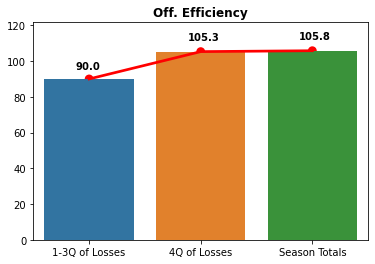

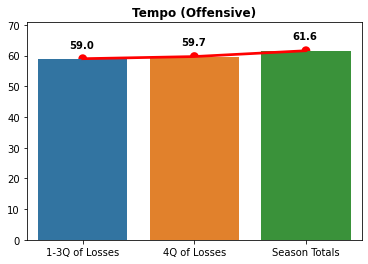

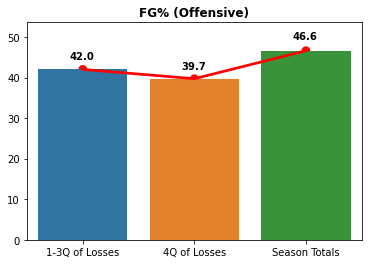

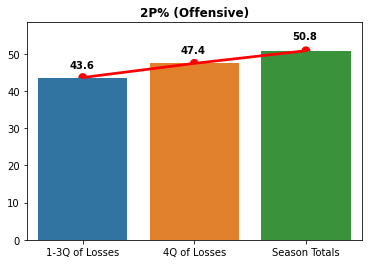

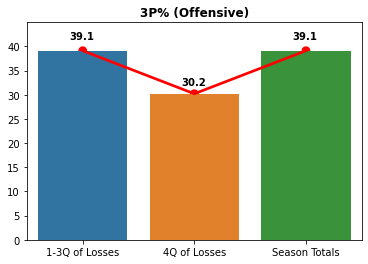

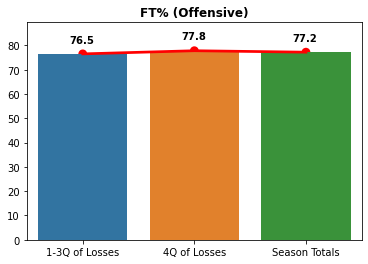

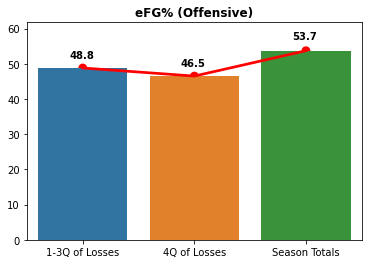

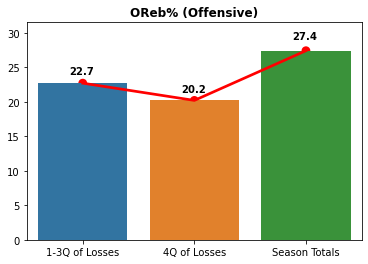

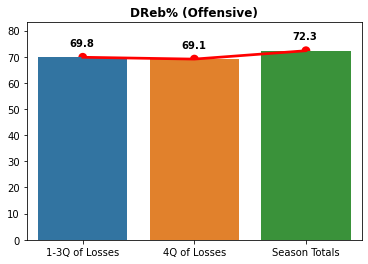

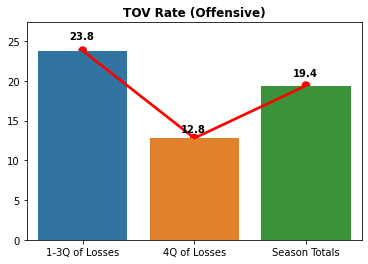

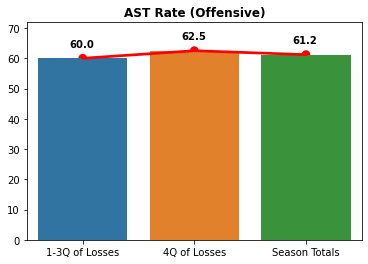

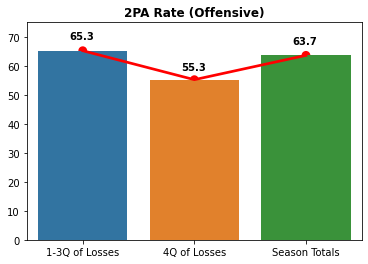

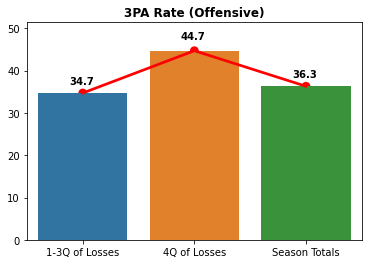

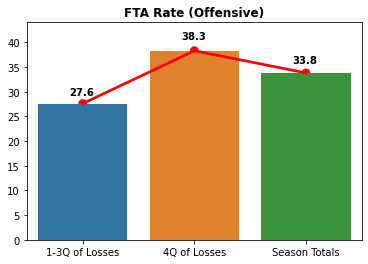

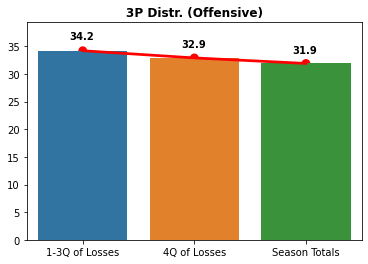

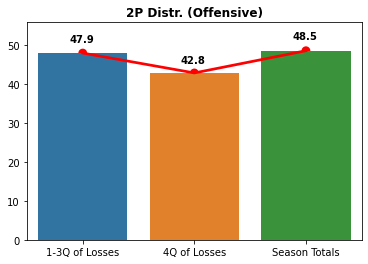

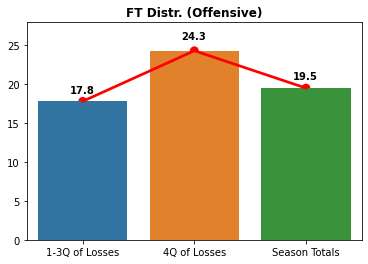

In [481]:
for i, var in enumerate(off_stats.iloc[:, 1:]):
    plt.figure(i)
    sns.barplot(x = 'Period', y = var, data = off_stats);
    sns.pointplot(x = 'Period', y = var, color = 'red', data = off_stats);
    if var == 'Off. Efficiency':
        plt.title(var, fontweight = 'bold')
    else:
        plt.title(var + ' (Offensive)', fontweight = 'bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(top = 1.15 * max(off_stats[var]))
    # add value labels
    for i, val in enumerate(off_stats[var]):
        plt.text(i - 0.12, 1.06 * val, val, color = 'black', fontweight = 'bold')

# DEFENSIVE ANALYSIS

## 4th Quarter

In [482]:
# start with zero counts
counts = init_zero_counts()

for url in game_urls:
    
    td_elements = extract_td_elements(url, 'pbp-q4')

    pbp = create_pbp_df(td_elements, Harrison = False)

    def_counts_4th = count_stats(pbp, counts)

In [508]:
def_counts_4th

{'PTS': 197,
 'FTM': 90,
 'FTA': 126,
 '2PM': 43,
 '2PA': 68,
 '3PM': 7,
 '3PA': 23,
 'FGM': 50,
 'FGA': 91,
 'REB': 84,
 'OREB': 17,
 'DREB': 67,
 'AST': 33,
 'TOV': 24}

In [483]:
# input to 4Q adv_stats formula
d_possessions_4th = def_counts_4th['FGA'] - def_counts_4th['OREB'] + def_counts_4th['TOV'] + 0.475 * def_counts_4th['FTA']
d_possessions_4th

157.85

In [484]:
def_adv_stats_4th = compute_adv_stats(def_counts_4th, 'Def.', MIN = 88, 
                                      opp_OREB = 16, opp_DREB = 39,
                                      o_poss = 170.65, d_poss = 157.85)

def_adv_stats_4th = pd.DataFrame.from_dict(def_adv_stats_4th,
                                           orient = 'index',
                                           columns = ['4Q of Losses'])

def_adv_stats_4th = round(def_adv_stats_4th * 100, 1)

#def_adv_stats_4th

## 1st - 3rd Quarter

In [485]:
# start with zero counts
counts = init_zero_counts()

for url in game_urls:
    
    td_elements = extract_td_elements(url, ['pbp-q1', 'pbp-q2', 'pbp-q3'])

    pbp = create_pbp_df(td_elements, Harrison = False)

    def_counts_1st3rd = count_stats(pbp, counts)

In [486]:
# input to 1-3Q adv_stats formula
d_possessions_1st3rd = def_counts_1st3rd['FGA'] - def_counts_1st3rd['OREB'] + def_counts_1st3rd['TOV'] + 0.475 * def_counts_1st3rd['FTA']
d_possessions_1st3rd

483.35

In [487]:
def_adv_stats_1st3rd = compute_adv_stats(def_counts_1st3rd, 'Def.', MIN = 264, 
                                         opp_OREB = 43, opp_DREB = 142,
                                         o_poss = 489.45, d_poss = 483.35)$

def_adv_stats_1st3rd = pd.DataFrame.from_dict(def_adv_stats_1st3rd,
                                              orient = 'index',
                                              columns = ['1-3Q of Losses'])

def_adv_stats_1st3rd = round(def_adv_stats_1st3rd * 100, 1)

#def_adv_stats_1st3rd

## Season Stats

In [488]:
# gathered from HHS Basketball Analytics website
def_season_totals = {'Def. Efficiency': 94.2,
                     'Tempo': 61.6,
                     'FG%': 44.1,
                     '2P%': 51.5,
                     '3P%': 30.4,
                     'FT%': 65.6,
                     'eFG%': 49.5,
                     'OReb%': 27.7,
                     'DReb%': 72.6,
                     'TOV Rate': 22.2,
                     'AST Rate': 50.9,
                     '2PA Rate': 64.9,
                     '3PA Rate': 35.1,
                     'FTA Rate': 36.1,
                     '3P Distr.': 26.2,
                     '2P Distr.': 54.5,
                     'FT Distr.': 19.3}

def_season_totals = pd.DataFrame.from_dict(def_season_totals, 
                                           orient = 'index',
                                           columns = ['Season Totals'])

## Comparison

In [489]:
stats = pd.concat([def_adv_stats_1st3rd, def_adv_stats_4th, def_season_totals], axis = 1)
def_stats = stats.T
def_stats

,Def. Efficiency,Tempo,FG%,2P%,3P%,FT%,eFG%,OReb%,DReb%,TOV Rate,AST Rate,2PA Rate,3PA Rate,FTA Rate,3P Distr.,2P Distr.,FT Distr.
1-3Q of Losses,104.2,59.0,47.6,56.5,32.2,73.6,53.5,30.4,77.6,19.3,58.6,63.6,36.4,26.4,27.8,56.8,15.4
4Q of Losses,119.9,59.7,54.9,63.2,30.4,71.4,58.8,30.4,80.7,14.6,66.0,74.7,25.3,138.5,10.7,43.7,45.7
Season Totals,94.2,61.6,44.1,51.5,30.4,65.6,49.5,27.7,72.6,22.2,50.9,64.9,35.1,36.1,26.2,54.5,19.3


In [490]:
def_stats = def_stats.reset_index().rename(columns = {'index': 'Period'})

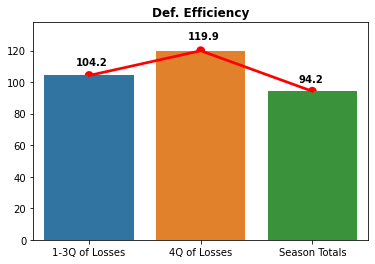

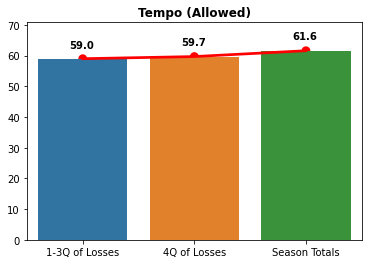

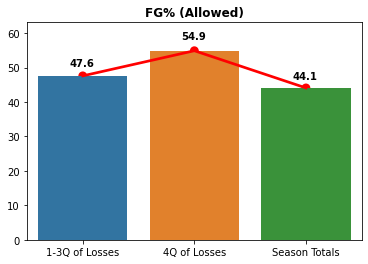

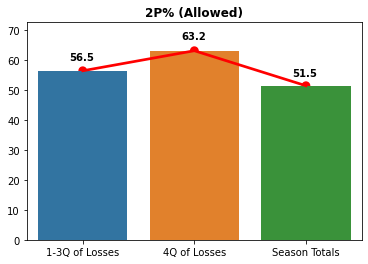

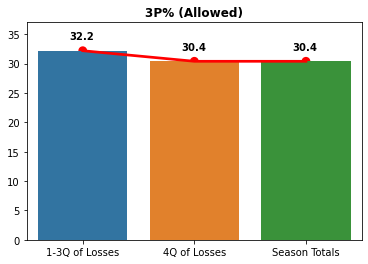

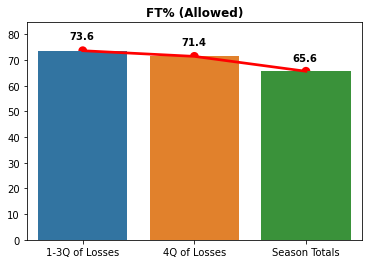

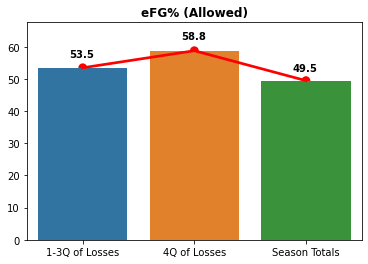

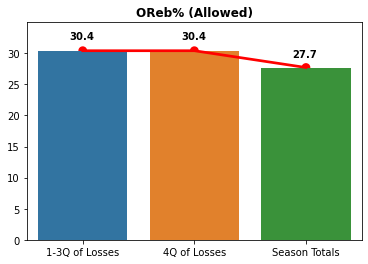

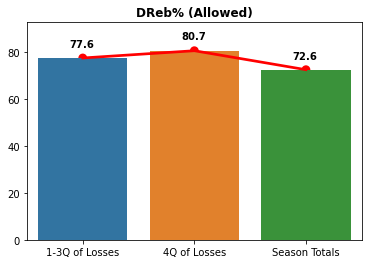

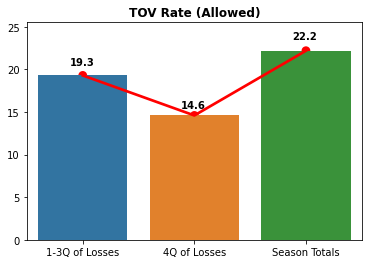

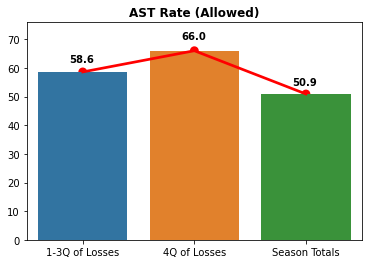

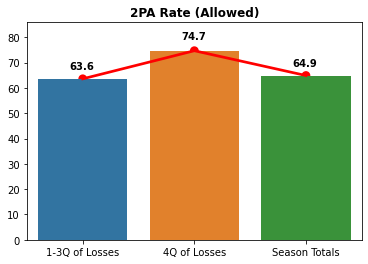

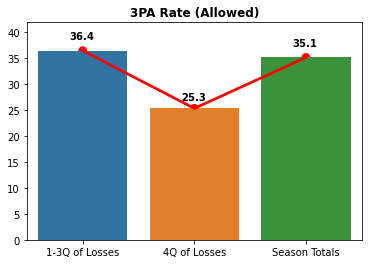

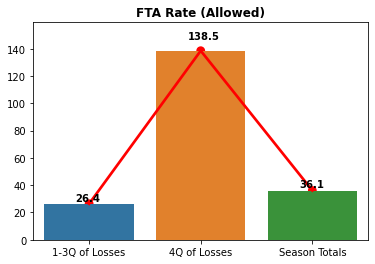

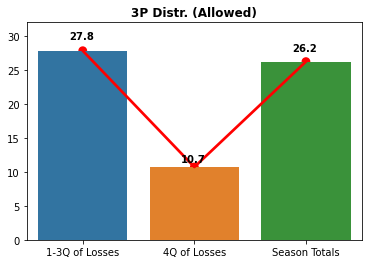

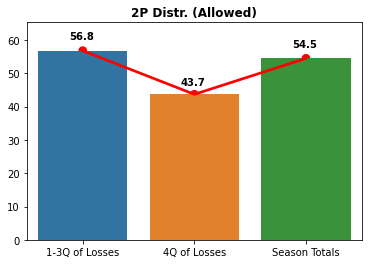

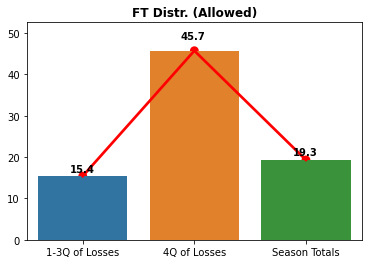

In [491]:
for i, var in enumerate(def_stats.iloc[:, 1:]):
    plt.figure(i)
    sns.barplot(x = 'Period', y = var, data = def_stats);
    sns.pointplot(x = 'Period', y = var, color = 'red', data = def_stats);
    if var == 'Def. Efficiency':
        plt.title(var, fontweight = 'bold')
    else:
        plt.title(var + ' (Allowed)', fontweight = 'bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(top = 1.15 * max(def_stats[var]))
    # add value labels
    for i, val in enumerate(def_stats[var]):
        plt.text(i - 0.12, 1.06 * val, val, color = 'black', fontweight = 'bold')

In [492]:
# check for pbp logging errors in OREB calculation

from collections import Counter

plays = []

for url in game_urls:
    
    td_elements = extract_td_elements(url, ['pbp-q1', 'pbp-q2', 'pbp-q3', 'pbp-q4'])

    # create df from tds
    # each td (play) correspopnds to a row in df
    pbp = pd.DataFrame(td_elements, columns = ['Empty', 'Team', 'Play', 'Time', 'Score'])

    # drop irrelevant columns
    pbp = pbp.drop(columns = ['Empty', 'Time'])[1:]

    # separate player from 'Play' column into own column ('Player')
    new_play = pbp["Play"].str.split(" by ", n = 1, expand = True) 
    pbp["Play"]= new_play[0] 
    pbp.insert(2, "Player", new_play[1])
    pbp['Player'] = pbp['Player'].astype('string')

    # split 'Play' column to action ('Play') and outcome of shot if action was a shot ('Shot Result')
    shot_result = pbp["Play"].str.split(" shot ", n = 1, expand = True) 
    pbp["Play"]= shot_result[0] 
    pbp.insert(2, "Shot Result", shot_result[1])

    # filter out substitutions, and fouls
    pbp = pbp[pbp['Player'] != 'None']

    # drop irrelevant columns
    pbp = pbp.drop(columns = ['Player', 'Score']) \
             .reset_index()
    
    # return all plays prior to a Rebound
    for index, row in pbp.iterrows():
        if row['Play'] == 'Rebound':
            play = pbp.iloc[index - 1]['Play']
            plays.append(play)

# list of all plays prior to a Rebound
plays

# count # of occurrences of each play type that comes before a Rebound
Counter(plays)

Counter({'2 point': 273,
         '3 point': 205,
         'Rebound': 4,
         '1 point': 48,
         'Turnover': 3,
         'Assist': 1,
         'Shot blocked': 1})